In [11]:
# 0. Connect your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/PersonalProjects
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PersonalProjects
Blob_GPT_Merge.csv	       merged_df.csv		       TextBlob.jsonl
hotel_reviews_plain.json       output.jsonl		       TextBlob_labeled.csv
manual_label_hotels_json.json  raw_hotelreviews.json	       TextClassifierAnalysis.ipynb
manual_label_hotels.jsonl      sentiment-gpt3-annotated.jsonl


In [23]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import altair as alt

In [13]:
!pip install altair_viewer

The data for this project was web-scraped from Google's travel site. I specifically looked for hotel reviews because I wanted to expand on what I learned in my NLP class with two different classification methods. Additionally, I am curious to understand how people feel about this smaller hotel chain as I am preparing my FIFA 2026 tournament plans; I specifcally wanted to look outside of common chains like Hilton and Marriot.

In [14]:
df = pd.read_json("raw_hotelreviews.json")

In [15]:
df.drop(columns=['name','reply date','time','Unnamed: 0', 'hotel reply','timestamp'], inplace=True)
df.head(3)
#dropped hotel reply and name as they contained reviewers names, reply_date, time, timestamp, and unamed: 0 were all unecessary

,ID,hotel,rating,site,trip type,room rating,location rating,service rating,text
0,0,Ace Hotel Brooklyn,5/5,Google,Solo,5.0,5.0,5.0,"This hotel is truly amazing, from the building..."
1,1,Ace Hotel Brooklyn,5/5,Google,Couple,5.0,5.0,5.0,The staff was terrific!. Geneva and Sergio wer...
2,2,Ace Hotel Brooklyn,5/5,Google,Vacation · Couple,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...


# Data Cleaning

In [16]:
df.shape

(10770, 9)

In [17]:
# Checking for missing values in the 'text' column which are the hotel reviews
missing_reviews = df['text'].isnull().sum()
# Removing any rows where the text column is missing
hotel_reviews_df_cleaned = df.dropna(subset=['text'])
print("Original number of reviews:", df.shape[0])
print("Number of missing reviews:", missing_reviews)
print("Number of reviews after cleaning:", hotel_reviews_df_cleaned.shape[0])

Original number of reviews: 10770
Number of missing reviews: 3725
Number of reviews after cleaning: 7045


In [18]:
hotel_reviews_df_cleaned["trip type"].unique()

array(['Solo', 'Couple', 'Vacation · Couple', None, 'Business',
       'Friends · Vacation', 'Couple · Vacation', 'Vacation', 'Family',
       'Friends', 'Vacation · Solo', 'Vacation · Family',
       'Friends · Business', 'Vacation · Friends', 'Family · Vacation',
       'Vacation · Family · Friends · Couple', 'Business · Solo',
       'Vacation · Family · Business', 'Business · Vacation · Friends',
       'Vacation · Couple · Business',
       'Business · Vacation · Couple · Solo',
       'Vacation · Couple · Friends', 'Friends · Vacation · Couple',
       'Solo · Couple', 'Couple · Business',
       'Couple · Friends · Family · Vacation',
       'Family · Friends · Vacation', 'Business · Solo · Vacation',
       'Vacation · Business · Couple', 'Solo · Vacation'], dtype=object)

In [19]:
# Changing 'NaN' to 'None' for grouping purposes
hotel_reviews_df_cleaned['trip type'] = hotel_reviews_df_cleaned['trip type'].fillna('None')

# Splitting trip type into individual categories and exploding the DataFrame
trip_types_expanded = hotel_reviews_df_cleaned['trip type'].str.split(' · ').explode()

data_expanded = hotel_reviews_df_cleaned.loc[trip_types_expanded.index].copy()
data_expanded['trip type'] = trip_types_expanded

<ipython-input-19-4d4d8b18271d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel_reviews_df_cleaned['trip type'] = hotel_reviews_df_cleaned['trip type'].fillna('None')


# Feature Engineering

In [20]:
#Converted rating column into numeric value for visualization. '5/5'-> 5.0
data_expanded['rating'] = data_expanded['rating'].apply(lambda x: float(x[0]))
data_expanded.head(3)

,ID,hotel,rating,site,trip type,room rating,location rating,service rating,text
0,0,Ace Hotel Brooklyn,5.0,Google,Solo,5.0,5.0,5.0,"This hotel is truly amazing, from the building..."
1,1,Ace Hotel Brooklyn,5.0,Google,Couple,5.0,5.0,5.0,The staff was terrific!. Geneva and Sergio wer...
2,2,Ace Hotel Brooklyn,5.0,Google,Vacation,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...


# Exploratory Visualizations

Although this isn't related to text classification, I was curious to see the distribution of ratings for the different categories. Of the three rating categories (Room, Service, Location), service had the highest frequency of 1 star reviews.

In [21]:
room_ratings = data_expanded["room rating"].value_counts().reset_index(name="count")
service_ratings = data_expanded["service rating"].value_counts().reset_index(name="count")
location_ratings = data_expanded["location rating"].value_counts().reset_index(name="count")
ratings_count = data_expanded["rating"].value_counts().reset_index(name="count")

In [24]:
room_chart = alt.Chart(room_ratings).mark_bar().encode(
    x = alt.X("index:N", title="Room Rating"),
    y = alt.Y("count:Q", title="Number of Reviews"),
    color = alt.Color("index:N", legend=None)
).properties(
    title = "Room Rating Distribution"
)
room_chart

alt.Chart(...)

In [25]:
service_chart = alt.Chart(service_ratings).mark_bar().encode(
    x = alt.X("index:N", title="Service Rating"),
    y = alt.Y("count:Q", title="Number of Reviews"),
    color = alt.Color("index:N", legend=None)
).properties(
    title = "Service Rating Distribution"
)
service_chart

alt.Chart(...)

In [26]:
location_chart = alt.Chart(location_ratings).mark_bar().encode(
    x = alt.X("index:N", title="Location Rating"),
    y = alt.Y("count:Q", title="Number of Reviews"),
    color = alt.Color("index:N", legend=None)
).properties(
    title = "Location Rating Distribution"
)
location_chart

alt.Chart(...)

In [28]:
ratings_chart = alt.Chart(ratings_count).mark_bar().encode(
    x = alt.X("index:N", title="Rating"),
    y = alt.Y("count:Q", title="Number of Reviews"),
    color = alt.Color("index:N", legend=None)
).properties(
    title = "Overall Rating Distribution"
)
ratings_chart

alt.Chart(...)

There is an overwhelming majority of 5 star reviews across all of the different ratings categories. What about the average ratings across the self described trip types?

In [32]:
#Average ratings for room, location, and service by trip type
average_ratings_by_trip_type = data_expanded.groupby('trip type').agg({
    'room rating': 'mean',
    'location rating': 'mean',
    'service rating': 'mean',
    'rating': 'mean'
}).reset_index()

average_ratings_by_trip_type

,trip type,room rating,location rating,service rating,rating
0,Business,4.200000,4.600000,4.000000,3.865385
1,Couple,3.467742,4.203125,3.738462,3.318841
2,Family,3.388889,4.315789,4.000000,3.190476
3,Friends,4.125000,4.516129,4.382353,3.916667
4,None,4.307692,4.466667,4.133333,4.378629
5,Solo,4.625000,4.941176,4.750000,4.428571
6,Vacation,3.715596,4.431193,3.687500,3.530769


"Solo" trip type tend to have the highest average ratings across room, location, and service, while "Family" and "Vacation" trip types have lower averages across all rating categories. The "None" category, representing missing or unspecified trip types, also shows relatively high average ratings. This makes sense as most customers who leave reviews either have very postive or very negative experiences.

Sentiment Analysis

In [33]:
# Sentiment Analysis using TextBlob
def analyze_sentiment(review):
    analysis = TextBlob(review)
    return analysis.sentiment.polarity  # Polarity score

# Apply sentiment analysis to each review

In [34]:
# Assigning sentiment labels based on sentiment score
def assign_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

In [35]:
data_expanded['sentiment_score'] = data_expanded['text'].apply(analyze_sentiment)

In [36]:
data_expanded['sentiment_label'] = data_expanded['sentiment_score'].apply(assign_label)

In [38]:
data_expanded.head(4)

,ID,hotel,rating,site,trip type,room rating,location rating,service rating,text,sentiment_score,sentiment_label
0,0,Ace Hotel Brooklyn,5.0,Google,Solo,5.0,5.0,5.0,"This hotel is truly amazing, from the building...",0.411738,Positive
1,1,Ace Hotel Brooklyn,5.0,Google,Couple,5.0,5.0,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,Positive
2,2,Ace Hotel Brooklyn,5.0,Google,Vacation,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive
2,2,Ace Hotel Brooklyn,5.0,Google,Couple,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive


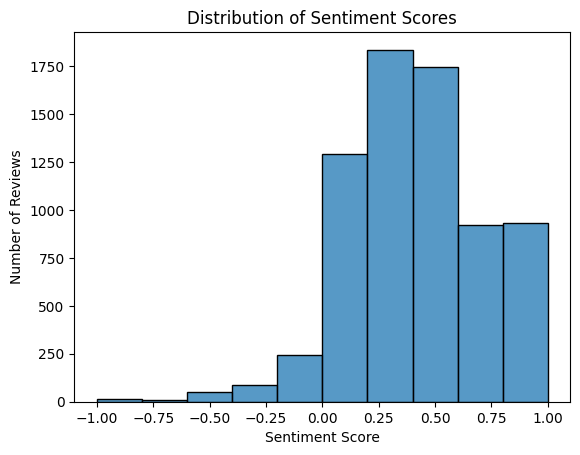

In [ ]:
# Distribution of the sentiment scores, they are mostly positive and right skewed
sns.histplot(data_expanded['sentiment_score'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiment Scores')
plt.show()


Most text reviews have less than 500 characters. It would be interesting to see what the larger character reviews have to say.

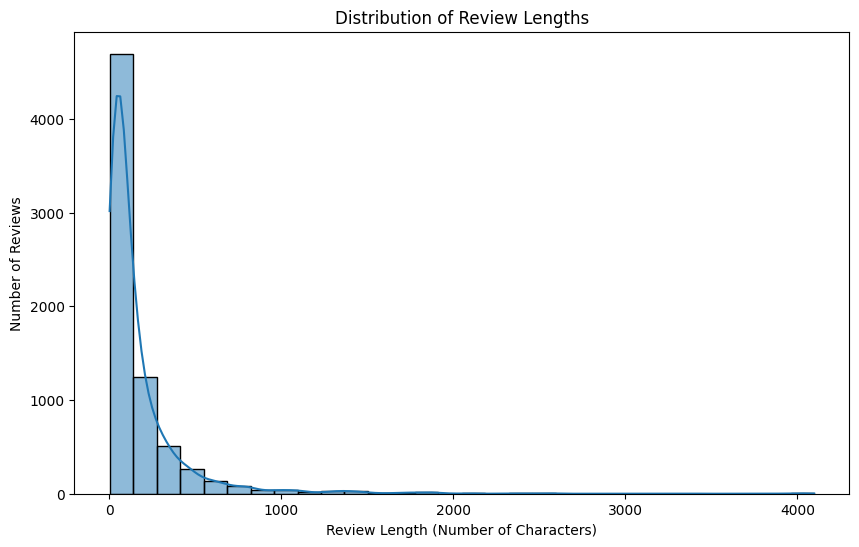

In [ ]:
data_expanded['review_length'] = data_expanded['text'].apply(len)
# Visualization of Review Length
plt.figure(figsize=(10, 6))
sns.histplot(data=data_expanded, x='review_length', bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Characters)')
plt.ylabel('Number of Reviews')
plt.show()

Note that Ace Hotel Toronto only has 1 Review in the dataset. I am not examining reviews by hotel location but it is interesting to keep track of.

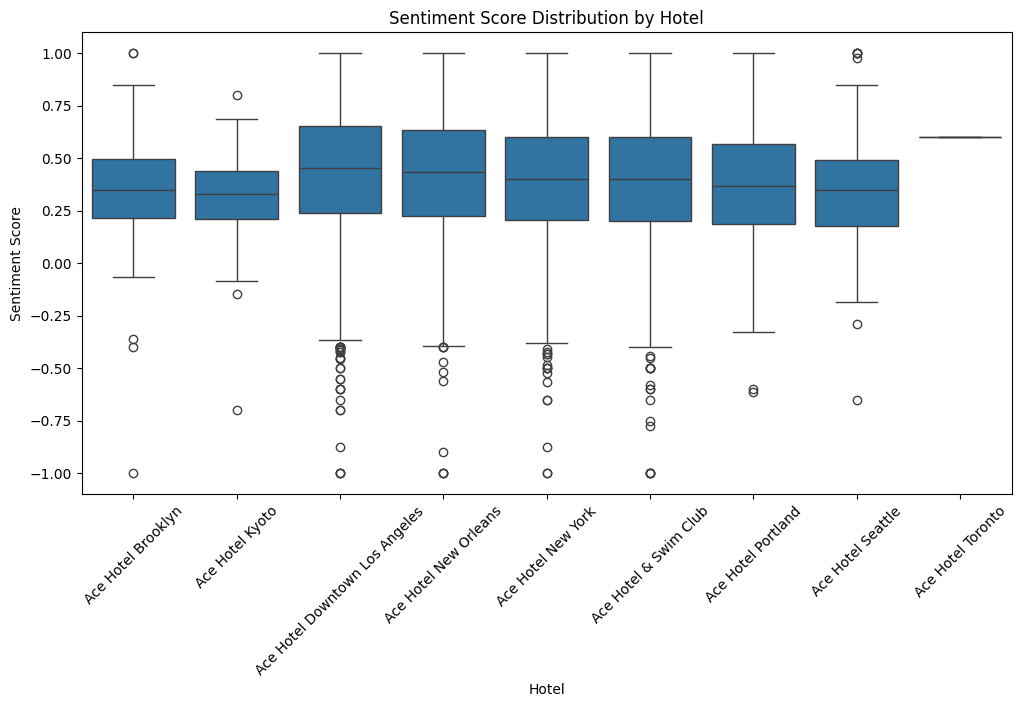

In [ ]:
# Creating a Boxplot of Sentiment Scores by Hotel (if applicable)
# Assuming 'hotel' is a column in your DataFrame
plt.figure(figsize=(12, 6))
sns.boxplot(x='hotel', y='sentiment_score', data=data_expanded)
plt.xticks(rotation=45)
plt.title('Sentiment Score Distribution by Hotel')
plt.xlabel('Hotel')
plt.ylabel('Sentiment Score')
plt.show()

#GPT3-5 Turbo Data

After uploading the raw review data into Prodigy, I used a recipe to connect my api key to openai. Lastly, I had to give the api a detailed prompt in order for GPT3-5Turbo to classify each sentence as Positive or Negative.

https://prodi.gy/docs

Prompt given to openai: "You are an expert Text Classification system. Your task is to accept Text as input and provide a category for the text based on the predefined labels. Classify the text below to any of the following labels: NEGATIVE, POSITIVE. The task is non-exclusive, so you can provide more than one label as long as they're comma-delimited. For example: Label1, Label2, Label3. Do not put any other text in your answer, only one or more of the provided labels with nothing before or after. If the text cannot be classified into any of the provided labels, answer `==NONE==`. Below are definitions of each label to help aid you in correctly classifying the text. Assume these definitions are written by an expert and follow them closely. POSITIVE: A positively sentiment review. NEGATIVE: A negatively sentiment review. Here is the text that needs classification:"

In [3]:
gpt = pd.read_json('sentiment-gpt3-annotated.jsonl', lines=True)
gpt.head(10)

,text,_input_hash,_task_hash,options,accept,llm,_view_id
0,"This hotel is truly amazing, from the building...",1344630365,-1649013736,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
1,The staff was terrific!. Geneva and Sergio wer...,534808085,-1127637961,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
2,Amazing stay for our first evening in Brooklyn...,422006770,1373478981,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
3,"What an amazing place! Clean, quiet rooms and ...",913662917,873784749,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
4,Huge thank you to Darren at the front desk who...,1580355780,857685181,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
5,"As a newly former New Yorker, I am now always ...",-1340859968,-2017473298,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
6,Lovely hotel in great location. I was here for...,988124567,835912987,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
7,"Love the Ace Hotel Brooklyn, great spot for br...",328728841,1111961170,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice
8,The is another gimmicky NYC hotel with undersi...,-548669807,-857473328,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[NEGATIVE],{'prompt': ['You are an expert Text Classifica...,choice
9,Couldn’t stop singing the praises for my exper...,-1793216809,1924072750,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",[POSITIVE],{'prompt': ['You are an expert Text Classifica...,choice


In [61]:
gpt.shape

(6657, 7)

In [5]:
# Converting the list of determined labels to a string
gpt['accept'] = gpt['accept'].apply(lambda x: x[0] if x else None)
gpt.head(10)

,text,_input_hash,_task_hash,options,accept,llm,_view_id
0,"This hotel is truly amazing, from the building...",1344630365,-1649013736,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
1,The staff was terrific!. Geneva and Sergio wer...,534808085,-1127637961,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
2,Amazing stay for our first evening in Brooklyn...,422006770,1373478981,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
3,"What an amazing place! Clean, quiet rooms and ...",913662917,873784749,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
4,Huge thank you to Darren at the front desk who...,1580355780,857685181,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
5,"As a newly former New Yorker, I am now always ...",-1340859968,-2017473298,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
6,Lovely hotel in great location. I was here for...,988124567,835912987,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
7,"Love the Ace Hotel Brooklyn, great spot for br...",328728841,1111961170,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice
8,The is another gimmicky NYC hotel with undersi...,-548669807,-857473328,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",NEGATIVE,{'prompt': ['You are an expert Text Classifica...,choice
9,Couldn’t stop singing the praises for my exper...,-1793216809,1924072750,"[{'id': 'NEGATIVE', 'text': 'NEGATIVE', 'meta'...",POSITIVE,{'prompt': ['You are an expert Text Classifica...,choice


In [7]:
df_gpt = gpt[['text','accept']]
df_gpt.head(10)

,text,accept
0,"This hotel is truly amazing, from the building...",POSITIVE
1,The staff was terrific!. Geneva and Sergio wer...,POSITIVE
2,Amazing stay for our first evening in Brooklyn...,POSITIVE
3,"What an amazing place! Clean, quiet rooms and ...",POSITIVE
4,Huge thank you to Darren at the front desk who...,POSITIVE
5,"As a newly former New Yorker, I am now always ...",POSITIVE
6,Lovely hotel in great location. I was here for...,POSITIVE
7,"Love the Ace Hotel Brooklyn, great spot for br...",POSITIVE
8,The is another gimmicky NYC hotel with undersi...,NEGATIVE
9,Couldn’t stop singing the praises for my exper...,POSITIVE


#TextBlob Data

It was interesting to see 7100 observations from the textblob labeling compared to the GPT labeling, however what I learned is that the openai api automatically filters out duplicates when conducting tasks. TextBlob doesn't have that capability so duplicates need to be removed manually.

In [42]:
blob_data = data_expanded[['ID','hotel','rating','trip type','room rating','location rating','service rating','text','sentiment_score','sentiment_label']]
#blob_data = pd.read_csv("TextBlob_labeled.csv")
blob_data.head(10)

,ID,hotel,rating,trip type,room rating,location rating,service rating,text,sentiment_score,sentiment_label
0,0,Ace Hotel Brooklyn,5.0,Solo,5.0,5.0,5.0,"This hotel is truly amazing, from the building...",0.411738,Positive
1,1,Ace Hotel Brooklyn,5.0,Couple,5.0,5.0,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,Positive
2,2,Ace Hotel Brooklyn,5.0,Vacation,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive
2,2,Ace Hotel Brooklyn,5.0,Couple,5.0,5.0,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive
3,3,Ace Hotel Brooklyn,5.0,None,NaN,NaN,NaN,"What an amazing place! Clean, quiet rooms and ...",0.541667,Positive
4,4,Ace Hotel Brooklyn,5.0,Couple,4.0,4.0,5.0,Huge thank you to Darren at the front desk who...,0.245840,Positive
5,5,Ace Hotel Brooklyn,5.0,Business,3.0,3.0,5.0,"As a newly former New Yorker, I am now always ...",0.220042,Positive
6,6,Ace Hotel Brooklyn,5.0,None,NaN,NaN,NaN,Lovely hotel in great location. I was here for...,0.338636,Positive
7,7,Ace Hotel Brooklyn,5.0,None,NaN,NaN,NaN,"Love the Ace Hotel Brooklyn, great spot for br...",0.458333,Positive
8,8,Ace Hotel Brooklyn,3.0,None,NaN,NaN,NaN,The is another gimmicky NYC hotel with undersi...,0.137000,Positive


In [43]:
blob_data.shape

(7126, 10)

In [10]:
df_tb = blob_data[['hotel','rating','text','sentiment_score','sentiment_label']]

In [11]:
df_tb = df_tb.drop_duplicates(subset='text')
print(df_tb.shape)
df_tb.head(10)

(6657, 5)


,hotel,rating,text,sentiment_score,sentiment_label
0,Ace Hotel Brooklyn,5.0,"This hotel is truly amazing, from the building...",0.411738,Positive
1,Ace Hotel Brooklyn,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,Positive
2,Ace Hotel Brooklyn,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive
4,Ace Hotel Brooklyn,5.0,"What an amazing place! Clean, quiet rooms and ...",0.541667,Positive
5,Ace Hotel Brooklyn,5.0,Huge thank you to Darren at the front desk who...,0.245840,Positive
6,Ace Hotel Brooklyn,5.0,"As a newly former New Yorker, I am now always ...",0.220042,Positive
7,Ace Hotel Brooklyn,5.0,Lovely hotel in great location. I was here for...,0.338636,Positive
8,Ace Hotel Brooklyn,5.0,"Love the Ace Hotel Brooklyn, great spot for br...",0.458333,Positive
9,Ace Hotel Brooklyn,3.0,The is another gimmicky NYC hotel with undersi...,0.137000,Positive
10,Ace Hotel Brooklyn,5.0,Couldn’t stop singing the praises for my exper...,0.332823,Positive


#Merge the GPT and Text dataframes

In [14]:
merged_df = pd.merge(df_tb, df_gpt, on='text')
merged_df.head(10)

,hotel,rating,text,sentiment_score,sentiment_label,accept
0,Ace Hotel Brooklyn,5.0,"This hotel is truly amazing, from the building...",0.411738,Positive,POSITIVE
1,Ace Hotel Brooklyn,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,Positive,POSITIVE
2,Ace Hotel Brooklyn,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive,POSITIVE
3,Ace Hotel Brooklyn,5.0,"What an amazing place! Clean, quiet rooms and ...",0.541667,Positive,POSITIVE
4,Ace Hotel Brooklyn,5.0,Huge thank you to Darren at the front desk who...,0.245840,Positive,POSITIVE
5,Ace Hotel Brooklyn,5.0,"As a newly former New Yorker, I am now always ...",0.220042,Positive,POSITIVE
6,Ace Hotel Brooklyn,5.0,Lovely hotel in great location. I was here for...,0.338636,Positive,POSITIVE
7,Ace Hotel Brooklyn,5.0,"Love the Ace Hotel Brooklyn, great spot for br...",0.458333,Positive,POSITIVE
8,Ace Hotel Brooklyn,3.0,The is another gimmicky NYC hotel with undersi...,0.137000,Positive,NEGATIVE
9,Ace Hotel Brooklyn,5.0,Couldn’t stop singing the praises for my exper...,0.332823,Positive,POSITIVE


In [15]:
merged_df.rename(columns = {'sentiment_label':'TextBlob Label'}, inplace = True)
merged_df.rename(columns = {'accept':'GPT Label'}, inplace = True)

In [16]:
merged_df.rename(columns = {'sentiment_score':'TextBlob Sentiment Score'}, inplace = True)

In [63]:
merged_df.head(10)

,hotel,rating,text,TextBlob Sentiment Score,TextBlob Label,GPT Label
0,Ace Hotel Brooklyn,5.0,"This hotel is truly amazing, from the building...",0.411738,Positive,POSITIVE
1,Ace Hotel Brooklyn,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,Positive,POSITIVE
2,Ace Hotel Brooklyn,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,Positive,POSITIVE
3,Ace Hotel Brooklyn,5.0,"What an amazing place! Clean, quiet rooms and ...",0.541667,Positive,POSITIVE
4,Ace Hotel Brooklyn,5.0,Huge thank you to Darren at the front desk who...,0.245840,Positive,POSITIVE
5,Ace Hotel Brooklyn,5.0,"As a newly former New Yorker, I am now always ...",0.220042,Positive,POSITIVE
6,Ace Hotel Brooklyn,5.0,Lovely hotel in great location. I was here for...,0.338636,Positive,POSITIVE
7,Ace Hotel Brooklyn,5.0,"Love the Ace Hotel Brooklyn, great spot for br...",0.458333,Positive,POSITIVE
8,Ace Hotel Brooklyn,3.0,The is another gimmicky NYC hotel with undersi...,0.137000,Positive,NEGATIVE
9,Ace Hotel Brooklyn,5.0,Couldn’t stop singing the praises for my exper...,0.332823,Positive,POSITIVE


###There are quite a few instances of conflicting sentence interpretations, almost 16% of the entire dataset is unclear! Which one is wrong though?🤔

####Intial thoughts: even a .002 sentiment score for the textblob model will assign a sentence as positive when it may not be the case. It seems like gpt is more decisive on difficult sentences but it seems more prone to being confused by **any** negative words in a sentence regardless of the overall meaning...

Although I have merged the dataframe, some more data cleaning is needed in order to start making comparisons.

In [65]:
#Lowercased all values in gpt labeling and remapped the 'None' value to 'neutral' in order to compare results
merged_subset = merged_df[['hotel','rating','text','TextBlob Sentiment Score','TextBlob Label','GPT Label']]
merged_subset['GPT Label'] = merged_subset['GPT Label'].str.lower()
merged_subset['TextBlob Label'] = merged_subset['TextBlob Label'].str.lower()
merged_subset['GPT Label'] = merged_subset['GPT Label'].replace({None: 'neutral'})
merged_subset.head(5)

,hotel,rating,text,TextBlob Sentiment Score,TextBlob Label,GPT Label
0,Ace Hotel Brooklyn,5.0,"This hotel is truly amazing, from the building...",0.411738,positive,positive
1,Ace Hotel Brooklyn,5.0,The staff was terrific!. Geneva and Sergio wer...,0.343590,positive,positive
2,Ace Hotel Brooklyn,5.0,Amazing stay for our first evening in Brooklyn...,0.387708,positive,positive
3,Ace Hotel Brooklyn,5.0,"What an amazing place! Clean, quiet rooms and ...",0.541667,positive,positive
4,Ace Hotel Brooklyn,5.0,Huge thank you to Darren at the front desk who...,0.245840,positive,positive


There are 1,091 observations where the TextBlob and GPT labeling had different opinions.

In [66]:
BLOBvGPT = merged_subset[(merged_subset['TextBlob Label']!= merged_subset['GPT Label'])]
print(BLOBvGPT.shape)
BLOBvGPT.head(10)

(1091, 6)


,hotel,rating,text,TextBlob Sentiment Score,TextBlob Label,GPT Label
8,Ace Hotel Brooklyn,3.0,The is another gimmicky NYC hotel with undersi...,0.137000,positive,negative
12,Ace Hotel Brooklyn,3.0,"First the good, room is nice and spacious for ...",0.190911,positive,negative
15,Ace Hotel Brooklyn,1.0,"When we checked in, the room's toilet didn't f...",0.065645,positive,negative
28,Ace Hotel Brooklyn,1.0,I would avoid this place. The staff is pompou...,0.051515,positive,negative
39,Ace Hotel Brooklyn,3.0,Oh forgot to mention the shower issue - you ha...,0.475000,positive,negative
44,Ace Hotel Brooklyn,4.0,$ No coffee in room ! But staff was excellent ...,0.850000,positive,negative
47,Ace Hotel Brooklyn,5.0,Very convenient location .friendly staff. Sma...,-0.025000,negative,positive
65,Ace Hotel Brooklyn,5.0,Lit,0.000000,neutral,positive
66,Ace Hotel Brooklyn,5.0,Five star treatment,0.000000,neutral,positive
69,Ace Hotel Brooklyn,5.0,"𝘎𝘳𝘦𝘢𝘵 𝘭𝘰𝘤𝘢𝘵𝘪𝘰𝘯, 𝘣𝘦𝘢𝘶𝘵𝘪𝘧𝘶𝘭 𝘥𝘦𝘤𝘰𝘳.",0.000000,neutral,negative


###Create a bar chart to showcase the difference in positive, negative, and neutral labels for TextBlob and GPT

In [74]:
# Create new dataframes for GPT labeled and Text Blob labeled with their value counts

# For TextBlob labeled
textblob_counts = merged_subset['TextBlob Label'].value_counts().reset_index()
textblob_counts.columns = ['Label', 'Count']

# For GPT labeled
gpt_counts = merged_subset['GPT Label'].value_counts().reset_index()
gpt_counts.columns = ['Label', 'Count']

textblob_counts, gpt_counts


(      Label  Count
 0  positive   5902
 1  negative    386
 2   neutral    369,
       Label  Count
 0  positive   5534
 1  negative   1021
 2   neutral    102)

In [87]:
textblob_chart = alt.Chart(textblob_counts).mark_bar().encode(
    x=alt.X('Label:N', axis=alt.Axis(labelAngle=0)),  # Correctly set labelAngle here
    y='Count:Q',  # Specify the quantitative nature of 'Count' explicitly
    tooltip=['Label', 'Count']
).properties(
    width=600,  # Adjust the width of the chart
    height=400,  # Adjust the height of the chart
    title='TextBlob Classification Distribution'
).interactive()

In [86]:
gpt_chart = alt.Chart(gpt_counts).mark_bar().encode(
    x=alt.X('Label:N', axis=alt.Axis(labelAngle=0)),  # Correctly set labelAngle here
    y='Count:Q',  # Specify the quantitative nature of 'Count' explicitly
    tooltip=['Label', 'Count']
).properties(
    width=600,  # Adjust the width of the chart
    height=400,  # Adjust the height of the chart
    title='GPT-3.5 Turbo Classification Distribution'
).interactive()

In [91]:
combined_chart = alt.hconcat(textblob_chart, gpt_chart)

# Display the combined chart
combined_chart

alt.HConcatChart(...)

In [20]:
merged_df.iloc[322] #may delete or can pull out special sentences

hotel                                          Ace Hotel Downtown Los Angeles
rating                                                                    4.0
text                        The rooms here have a great setup and decor (i...
TextBlob Sentiment Score                                             0.233069
TextBlob Label                                                       Positive
GPT Label                                                            POSITIVE
Name: 322, dtype: object

#To measure which text classification method is better, I decided to insert some human interpretation into the testing. For the first 500 hotel reviews, I read through and labeled each entire observation as positive, negative, or neutral. The guide for my annotations will be included with this file.

I performed the labeling through Prodigy's ner.manual recipe.

In [21]:
labeled_500 = pd.read_json('manual_label_hotels.jsonl', lines=True)
labeled_500.head(10)

,text,_input_hash,_task_hash,_is_binary,tokens,_view_id,spans,answer,_timestamp,_annotator_id,_session_id
0,"This hotel is truly amazing, from the building...",1344630365,-1649013736,False,"[{'text': 'This', 'start': 0, 'end': 4, 'id': ...",ner_manual,"[{'start': 0, 'end': 1565, 'token_start': 0, '...",accept,1708015519,2024-02-15_11-19-01,2024-02-15_11-19-01
1,The staff was terrific!. Geneva and Sergio wer...,534808085,-1127637961,False,"[{'text': 'The', 'start': 0, 'end': 3, 'id': 0...",ner_manual,"[{'start': 0, 'end': 422, 'token_start': 0, 't...",accept,1708015531,2024-02-15_11-19-01,2024-02-15_11-19-01
2,Amazing stay for our first evening in Brooklyn...,422006770,1373478981,False,"[{'text': 'Amazing', 'start': 0, 'end': 7, 'id...",ner_manual,"[{'start': 0, 'end': 462, 'token_start': 0, 't...",accept,1708015536,2024-02-15_11-19-01,2024-02-15_11-19-01
3,"What an amazing place! Clean, quiet rooms and ...",913662917,873784749,False,"[{'text': 'What', 'start': 0, 'end': 4, 'id': ...",ner_manual,"[{'start': 0, 'end': 286, 'token_start': 0, 't...",accept,1708015541,2024-02-15_11-19-01,2024-02-15_11-19-01
4,Huge thank you to Darren at the front desk who...,1580355780,857685181,False,"[{'text': 'Huge', 'start': 0, 'end': 4, 'id': ...",ner_manual,[],accept,1708015558,2024-02-15_11-19-01,2024-02-15_11-19-01
5,"As a newly former New Yorker, I am now always ...",-1340859968,-2017473298,False,"[{'text': 'As', 'start': 0, 'end': 2, 'id': 0,...",ner_manual,"[{'start': 0, 'end': 1103, 'token_start': 0, '...",accept,1708015930,2024-02-15_11-19-01,2024-02-15_11-19-01
6,Lovely hotel in great location. I was here for...,988124567,835912987,False,"[{'text': 'Lovely', 'start': 0, 'end': 6, 'id'...",ner_manual,"[{'start': 0, 'end': 359, 'token_start': 0, 't...",accept,1708016104,2024-02-15_11-19-01,2024-02-15_11-19-01
7,"Love the Ace Hotel Brooklyn, great spot for br...",328728841,1111961170,False,"[{'text': 'Love', 'start': 0, 'end': 4, 'id': ...",ner_manual,"[{'start': 0, 'end': 293, 'token_start': 0, 't...",accept,1708016117,2024-02-15_11-19-01,2024-02-15_11-19-01
8,The is another gimmicky NYC hotel with undersi...,-548669807,-857473328,False,"[{'text': 'The', 'start': 0, 'end': 3, 'id': 0...",ner_manual,"[{'start': 0, 'end': 358, 'token_start': 0, 't...",accept,1708016235,2024-02-15_11-19-01,2024-02-15_11-19-01
9,Couldn’t stop singing the praises for my exper...,-1793216809,1924072750,False,"[{'text': 'Could', 'start': 0, 'end': 5, 'id':...",ner_manual,"[{'start': 0, 'end': 1386, 'token_start': 0, '...",accept,1708016322,2024-02-15_11-19-01,2024-02-15_11-19-01


In [24]:
# Function to read through metadata and pull out the actually decision for positive,negative,neutral.
def extract_labels(row):
    try:
        if isinstance(row['spans'], list):
            labels = [span['label'] for span in row['spans'] if isinstance(span, dict) and 'label' in span]
            return ', '.join(labels)
        else:
            return None
    except Exception as e:
        print(f"Error processing row: {e}")
        return None

                                                text     label
0  This hotel is truly amazing, from the building...  POSITIVE
1  The staff was terrific!. Geneva and Sergio wer...  POSITIVE
2  Amazing stay for our first evening in Brooklyn...  POSITIVE
3  What an amazing place! Clean, quiet rooms and ...  POSITIVE
4  Huge thank you to Darren at the front desk who...          


In [ ]:
# Apply the function to extract labels to a new column
labeled_500['label'] = labeled_500.apply(extract_labels, axis=1)

print(labeled_500[['text', 'label']].head())

In [25]:
labeled_500['label'].replace('', 'NEUTRAL', inplace=True)

In [89]:
labeled_500.head(5)

,text,_input_hash,_task_hash,_is_binary,tokens,_view_id,spans,answer,_timestamp,_annotator_id,_session_id,label
0,"This hotel is truly amazing, from the building...",1344630365,-1649013736,False,"[{'text': 'This', 'start': 0, 'end': 4, 'id': ...",ner_manual,"[{'start': 0, 'end': 1565, 'token_start': 0, '...",accept,1708015519,2024-02-15_11-19-01,2024-02-15_11-19-01,POSITIVE
1,The staff was terrific!. Geneva and Sergio wer...,534808085,-1127637961,False,"[{'text': 'The', 'start': 0, 'end': 3, 'id': 0...",ner_manual,"[{'start': 0, 'end': 422, 'token_start': 0, 't...",accept,1708015531,2024-02-15_11-19-01,2024-02-15_11-19-01,POSITIVE
2,Amazing stay for our first evening in Brooklyn...,422006770,1373478981,False,"[{'text': 'Amazing', 'start': 0, 'end': 7, 'id...",ner_manual,"[{'start': 0, 'end': 462, 'token_start': 0, 't...",accept,1708015536,2024-02-15_11-19-01,2024-02-15_11-19-01,POSITIVE
3,"What an amazing place! Clean, quiet rooms and ...",913662917,873784749,False,"[{'text': 'What', 'start': 0, 'end': 4, 'id': ...",ner_manual,"[{'start': 0, 'end': 286, 'token_start': 0, 't...",accept,1708015541,2024-02-15_11-19-01,2024-02-15_11-19-01,POSITIVE
4,Huge thank you to Darren at the front desk who...,1580355780,857685181,False,"[{'text': 'Huge', 'start': 0, 'end': 4, 'id': ...",ner_manual,[],accept,1708015558,2024-02-15_11-19-01,2024-02-15_11-19-01,NEUTRAL


Manually Labeled Subset

In [90]:
subset_500 = labeled_500[['text', 'label']]
subset_500['label'] = subset_500['label'].str.lower()
subset_500.head(5)

<ipython-input-90-f4c7c7fa5605>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_500['label'] = subset_500['label'].str.lower()


,text,label
0,"This hotel is truly amazing, from the building...",positive
1,The staff was terrific!. Geneva and Sergio wer...,positive
2,Amazing stay for our first evening in Brooklyn...,positive
3,"What an amazing place! Clean, quiet rooms and ...",positive
4,Huge thank you to Darren at the front desk who...,neutral


GPT Subset

In [35]:
subset_gpt = merged_subset[['text','GPT Label']]
subset_gpt.head(10)

,text,GPT Label
0,"This hotel is truly amazing, from the building...",positive
1,The staff was terrific!. Geneva and Sergio wer...,positive
2,Amazing stay for our first evening in Brooklyn...,positive
3,"What an amazing place! Clean, quiet rooms and ...",positive
4,Huge thank you to Darren at the front desk who...,positive
5,"As a newly former New Yorker, I am now always ...",positive
6,Lovely hotel in great location. I was here for...,positive
7,"Love the Ace Hotel Brooklyn, great spot for br...",positive
8,The is another gimmicky NYC hotel with undersi...,negative
9,Couldn’t stop singing the praises for my exper...,positive


TextBlob Subset

In [36]:
subset_textblob = merged_subset[['text','TextBlob Label']]

subset_textblob.head(10)

,text,TextBlob Label
0,"This hotel is truly amazing, from the building...",positive
1,The staff was terrific!. Geneva and Sergio wer...,positive
2,Amazing stay for our first evening in Brooklyn...,positive
3,"What an amazing place! Clean, quiet rooms and ...",positive
4,Huge thank you to Darren at the front desk who...,positive
5,"As a newly former New Yorker, I am now always ...",positive
6,Lovely hotel in great location. I was here for...,positive
7,"Love the Ace Hotel Brooklyn, great spot for br...",positive
8,The is another gimmicky NYC hotel with undersi...,positive
9,Couldn’t stop singing the praises for my exper...,positive


Confusion Matrix for correctly labeled reviews

In [44]:
# Merge DataFrames with only necessary variables
df_merged = pd.merge(subset_500, subset_gpt, on='text').merge(subset_textblob, on='text', suffixes=('manual', 'gpt', 'textblob'))
df_merged.head(10)
#Since I only had 500 observations in manual labeled, there is only 500 observations total in this merged df.

,text,label,GPT Label,TextBlob Label
0,"This hotel is truly amazing, from the building...",positive,positive,positive
1,The staff was terrific!. Geneva and Sergio wer...,positive,positive,positive
2,Amazing stay for our first evening in Brooklyn...,positive,positive,positive
3,"What an amazing place! Clean, quiet rooms and ...",positive,positive,positive
4,Huge thank you to Darren at the front desk who...,neutral,positive,positive
5,"As a newly former New Yorker, I am now always ...",positive,positive,positive
6,Lovely hotel in great location. I was here for...,positive,positive,positive
7,"Love the Ace Hotel Brooklyn, great spot for br...",positive,positive,positive
8,The is another gimmicky NYC hotel with undersi...,negative,negative,positive
9,Couldn’t stop singing the praises for my exper...,positive,positive,positive


In [53]:
df_merged['label'] = df_merged['label'].fillna('neutral')

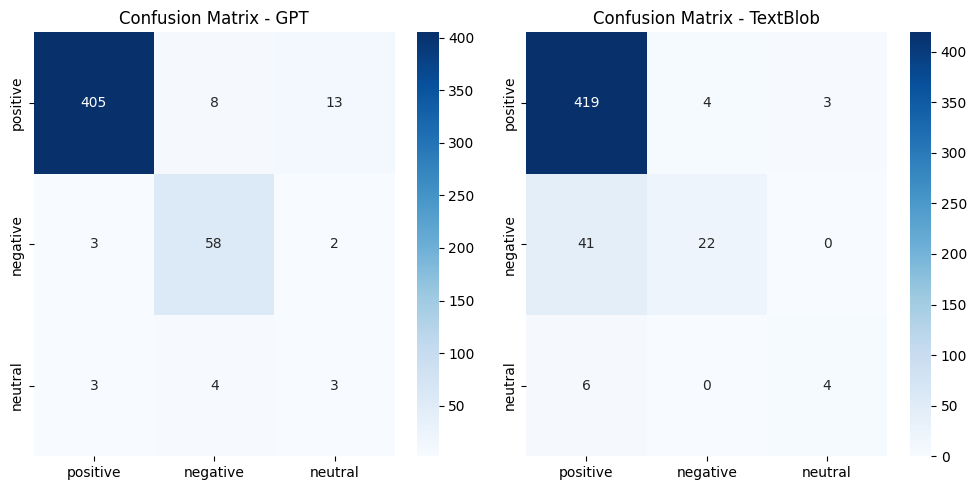

Accuracy - GPT: 0.93
Accuracy - TextBlob: 0.89


In [55]:
true_labels = df_merged['label'] #Manual Labeled
predicted_labels_gpt = df_merged['GPT Label']
predicted_labels_textblob = df_merged['TextBlob Label']

#Confusion matrices
conf_matrix_gpt = confusion_matrix(true_labels, predicted_labels_gpt, labels=['positive', 'negative', 'neutral'])
conf_matrix_textblob = confusion_matrix(true_labels, predicted_labels_textblob, labels=['positive', 'negative', 'neutral'])

# Visualize confusion matrices with a heatmap
plt.figure(figsize=(10, 5))
#GPT-3.5
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_gpt, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix - GPT')
#TextBlob
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_textblob, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.title('Confusion Matrix - TextBlob')
plt.tight_layout()
plt.show()

# Calculate accuracy scores
accuracy_gpt = accuracy_score(true_labels, predicted_labels_gpt)
accuracy_textblob = accuracy_score(true_labels, predicted_labels_textblob)

print(f'Accuracy - GPT: {accuracy_gpt:.2f}')
print(f'Accuracy - TextBlob: {accuracy_textblob:.2f}')


In [56]:
# Calculate precision, recall, and f1-score for GPT
precision_gpt = precision_score(true_labels, predicted_labels_gpt, average='weighted')
recall_gpt = recall_score(true_labels, predicted_labels_gpt, average='weighted')
f1_gpt = f1_score(true_labels, predicted_labels_gpt, average='weighted')

# Calculate precision, recall, and f1-score for TextBlob
precision_textblob = precision_score(true_labels, predicted_labels_textblob, average='weighted')
recall_textblob = recall_score(true_labels, predicted_labels_textblob, average='weighted')
f1_textblob = f1_score(true_labels, predicted_labels_textblob, average='weighted')

print('Metrics for GPT:')
print(f'Precision: {precision_gpt:.2f}')
print(f'Recall: {recall_gpt:.2f}')
print(f'F1-score: {f1_gpt:.2f}')

print('\nMetrics for TextBlob:')
print(f'Precision: {precision_textblob:.2f}')
print(f'Recall: {recall_textblob:.2f}')
print(f'F1-score: {f1_textblob:.2f}')


Metrics for GPT:
Precision: 0.95
Recall: 0.93
F1-score: 0.94

Metrics for TextBlob:
Precision: 0.88
Recall: 0.89
F1-score: 0.87


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Assuming 'label_manual', 'label_gpt', and 'label_textblob' are the columns with labels
unique_labels = ['positive', 'negative', 'neutral']

# Generate classification report for GPT
report_gpt = classification_report(true_labels, predicted_labels_gpt, labels=unique_labels)

# Generate classification report for TextBlob
report_textblob = classification_report(true_labels, predicted_labels_textblob, labels=unique_labels)

print('Classification Report for GPT:')
print(report_gpt)

print('\nClassification Report for TextBlob:')
print(report_textblob)


Classification Report for GPT:
              precision    recall  f1-score   support

    positive       0.98      0.95      0.97       426
    negative       0.83      0.92      0.87        63
     neutral       0.17      0.30      0.21        10

   micro avg       0.93      0.93      0.93       499
   macro avg       0.66      0.72      0.68       499
weighted avg       0.95      0.93      0.94       499


Classification Report for TextBlob:
              precision    recall  f1-score   support

    positive       0.90      0.98      0.94       426
    negative       0.85      0.35      0.49        63
     neutral       0.57      0.40      0.47        10

   micro avg       0.89      0.89      0.89       499
   macro avg       0.77      0.58      0.63       499
weighted avg       0.88      0.89      0.87       499



Conclusion

The performance metrics showcase the difference in ability for openai's 3.5 Turbo Generative Pre-trained Transformer and a python sentiment analysis library TextBlob. The metrics used included Precision, Recall, and F1-score, all of which are critical in classification models.

GPT-3.5 has higher precision (0.95), recall (0.93), and F1-score (0.94) compared to TextBlob. This means that GPT-3.5 had more accurate predictions and made fewer Type 1(false-positive, precision value) & 2(False-negative, recall value) errors. The F1-score also indicates a strong balance between precision and recall, making it an effective model.

TextBlob had lower over scores compared to GPT-3.5: precision (0.88), recall (0.89), and F1-score (0.87). I interpret these scores as a pretty good model, however GPT outperforms it in every aspect.

Takeaways:
Overall, the GPT-3.5 model is highly effective for labeling sentences. For the 6,557 reviews in varying length, it took roughly 2 hours to finish the task. Additionally, it cost $2.34 USD for the entire task. For cases where the cost may not be an issue, I would strongly recommend the GPT-3.5 model. However in the case of TextBlob, there is a free and well-trained library alternative for the same task. For only a slightly less powerful model that was completed in a fraction of the time, it may make sense to just use TextBlob.

This project exposed me to hands-on learning with api's, Ubuntu text line commands, the prodigy annotation tool, text analysis, manual training, and model eveluation. From all of my results and learning process, it seems like the Ace Hotels would be a great alternative to more popular hotel chains during the 2026 FIFA games! I may just need to avoid booking a room close to the rooftop bar and mentally prepare myself for less accomadating service, per the reviews 😀